In [13]:
from yahoo_fin import options as op
import yfinance as yf
import pandas as pd
import re
import ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [14]:
ticker = 'SPY'

In [15]:
symbol = "SPY"
start_date = "1999-01-01"  
end_date = "2024-04-15"  

In [16]:
option_hist_data = yf.download(symbol, start=start_date, end=end_date, actions=False)
print(option_hist_data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1999-01-04  123.375000  125.218750  121.718750  123.031250   78.329659   
1999-01-05  122.937500  124.875000  122.937500  124.437500   79.225029   
1999-01-06  125.812500  127.750000  125.750000  127.437500   81.134964   
1999-01-07  126.375000  127.218750  125.781250  126.812500   80.737099   
1999-01-08  128.187500  128.500000  125.968750  127.750000   81.333969   
...                ...         ...         ...         ...         ...   
2024-04-08  519.150024  520.179993  517.890015  518.719971  518.719971   
2024-04-09  520.500000  520.750000  514.349976  519.320007  519.320007   
2024-04-10  513.479980  516.159973  512.090027  514.119995  514.119995   
2024-04-11  515.679993  519.479980  512.080017  518.000000  518.000000   
2024-04-12  514.369995  515.820007  509.079987  510.850006  510.850006   

              Volume  
Date          

In [17]:
# Calculate SMA and RSI
data = option_hist_data.copy()
data['SMA'] = data['Close'].rolling(window=20).mean()
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate EMA
short_window = 12
long_window = 26
signal_window = 9
data['EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()

# Calculate MACD Histogram
def calculate_macd_histogram(data, short_window=12, long_window=26, signal_window=9):
    ema_short = data['Close'].ewm(span=short_window, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_histogram
data['MACD Histogram'] = calculate_macd_histogram(data)

# Calculate VWAP
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return upper_band, lower_band

data['Upper BB'], data['Lower BB'] = calculate_bollinger_bands(data)

# Calculate Stochastic Oscillator
def calculate_stochastic_oscillator(data, window=14):
    low_min = data['Low'].rolling(window=window).min()
    high_max = data['High'].rolling(window=window).max()
    k_percent = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    return k_percent

data['Stochastic Oscillator'] = calculate_stochastic_oscillator(data)

# Calculate Average True Range (ATR)
def calculate_atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

data['ATR'] = calculate_atr(data)

# Calculate On-Balance Volume (OBV)
def calculate_obv(data):
    obv = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    return obv

data['OBV'] = calculate_obv(data)

def calculate_mfi(data, window=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    money_flow = typical_price * data['Volume']
    money_flow_positive = np.where(typical_price.diff() > 0, money_flow, 0)
    money_flow_negative = np.where(typical_price.diff() < 0, money_flow, 0)
    positive_flow_sum = pd.Series(money_flow_positive).rolling(window=window).sum()
    negative_flow_sum = pd.Series(money_flow_negative).rolling(window=window).sum()
    
    # Avoid division by zero error
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = np.where(negative_flow_sum != 0, positive_flow_sum / negative_flow_sum, 0)
    
    mfi = 100 - (100 / (1 + money_ratio))
    return mfi

data['MFI'] = calculate_mfi(data)

# Calculate Chaikin Money Flow (CMF)
def calculate_cmf(data, window=20):
    money_flow_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    money_flow_volume = money_flow_multiplier * data['Volume']
    cmf = money_flow_volume.rolling(window=window).sum() / data['Volume'].rolling(window=window).sum()
    return cmf

data['CMF'] = calculate_cmf(data)

In [18]:
# Reset the index to default integer index before saving to CSV
data.reset_index(inplace=True)

# Drop rows with missing data
data.dropna(inplace=True)

# Save the modified DataFrame to CSV with the 'Date' column included
data.to_csv('OptionHistData.csv', columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'RSI', 'EMA', 'MACD Histogram', 'VWAP', 'Upper BB', 'Lower BB', 'Stochastic Oscillator', 'ATR', 'OBV', 'MFI', 'CMF'], index=False)

In [19]:
print(data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'RSI', 'EMA', 'MACD Histogram', 'VWAP', 'Upper BB', 'Lower BB', 'Stochastic Oscillator', 'ATR', 'OBV', 'MFI', 'CMF']])

           Date        Open        High         Low       Close   Adj Close  \
19   1999-02-01  128.687500  128.687500  126.906250  126.906250   80.796761   
20   1999-02-02  127.078125  127.218750  124.765625  126.125000   80.299385   
21   1999-02-03  125.687500  127.937500  125.656250  127.406250   81.115074   
22   1999-02-04  127.375000  127.500000  124.781250  125.500000   79.901436   
23   1999-02-05  125.656250  125.656250  123.218750  124.062500   78.986259   
...         ...         ...         ...         ...         ...         ...   
6355 2024-04-08  519.150024  520.179993  517.890015  518.719971  518.719971   
6356 2024-04-09  520.500000  520.750000  514.349976  519.320007  519.320007   
6357 2024-04-10  513.479980  516.159973  512.090027  514.119995  514.119995   
6358 2024-04-11  515.679993  519.479980  512.080017  518.000000  518.000000   
6359 2024-04-12  514.369995  515.820007  509.079987  510.850006  510.850006   

        Volume         SMA        RSI         EMA  

<Axes: >

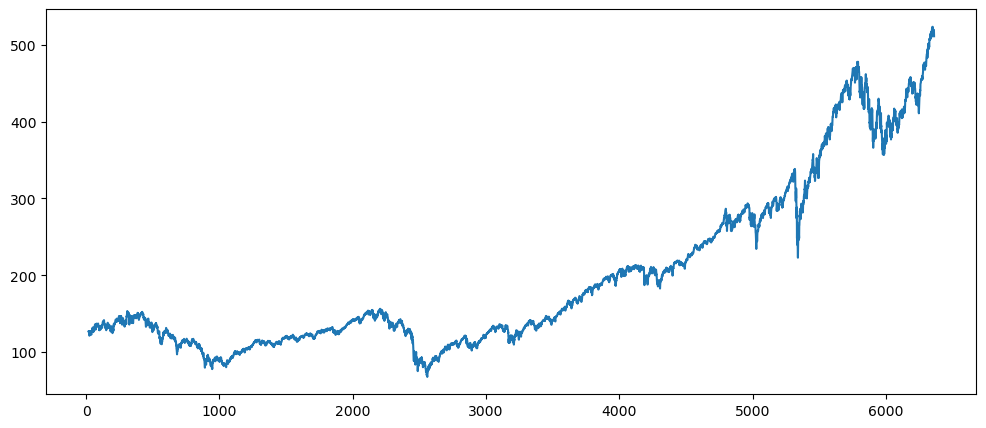

In [20]:
data['Close'].plot(figsize=(12,5))

In [21]:
#checking for stationarity
def ad_test(data): 
    dftest = adfuller(data, autolag = 'AIC')
    print("ADF:", dftest[0])
    print("P-Value", dftest[1])
    print("Num of Lags", dftest[2])
    print("Num of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [22]:
ad_test(data['Close'])

ADF: 2.0290999648351367
P-Value 0.998709590865513
Num of Lags 32
Num of Observations Used For ADF Regression and Critical Values Calculation : 6308
Critical Values :
	 1% :  -3.4313870898956207
	 5% :  -2.861998302507518
	 10% :  -2.5670139513803973


Epoch 1/50


C:\Users\Quent Titre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0457 - val_loss: 1.3982e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.3081e-04 - val_loss: 1.0942e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3570e-04 - val_loss: 1.2032e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1022e-04 - val_loss: 9.9523e-05
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1172e-04 - val_loss: 9.4219e-05
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1472e-04 - val_loss: 1.2186e-04
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0478e-04 - val_loss: 1.3690e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3262e-04 - val_loss: 8.7422e-05
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.3925e-05 - val_loss: 8.5197e-05
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0212e-04 - val_loss: 9.1560e-05
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.

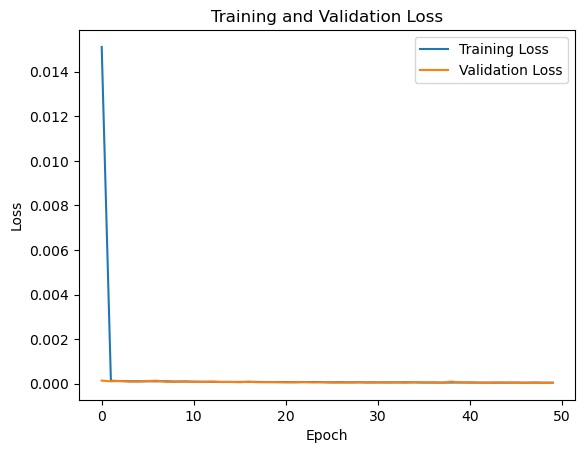

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Test Set Performance Metrics:
Mean Squared Error: 10.883189003704011
Mean Absolute Error: 2.089644754008883
R-squared: 0.9990219638884962

Actual vs Predicted Values on Test Set:
         Actual   Predicted
0    383.790009  383.425720
1     75.620003   76.893654
2    115.720001  116.421516
3    129.710007  132.239304
4     89.650002   91.117172
..          ...         ...
623  437.250000  436.318695
624  110.410004  108.959496
625  163.559998  163.989532
626  135.110001  134.696014
627  109.989998  109.604744

[628 rows x 2 columns]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predictions for the Next 6 Days:
[[515.618  ]
 [514.8936 ]
 [514.0157 ]
 [513.0447 ]
 [512.0161 ]
 [510.95572]]


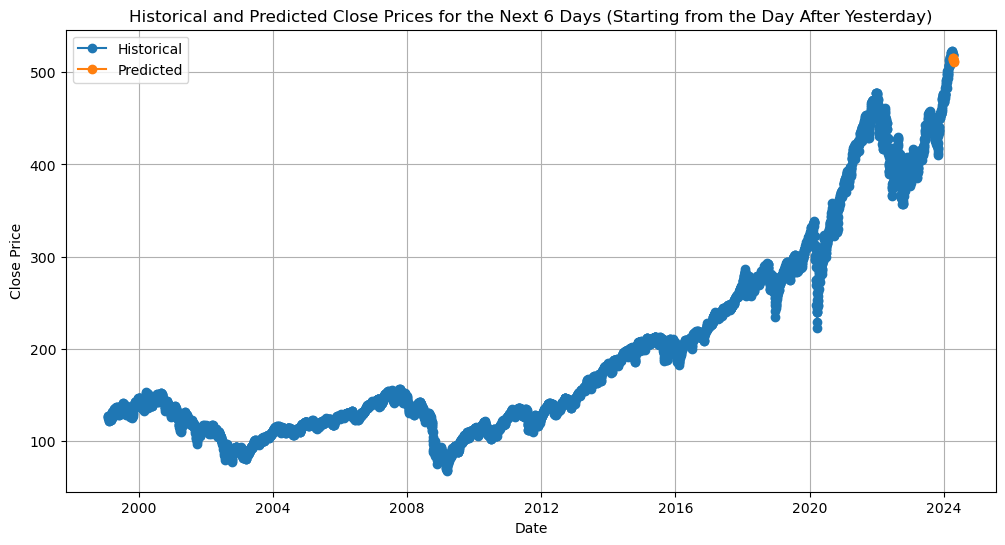

In [23]:
# Load historical data
data = pd.read_csv('OptionHistData.csv', parse_dates=['Date'])

# Assuming 'features' and 'target' are defined as before
features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'RSI', 'EMA', 'MACD Histogram', 'VWAP', 'Upper BB', 'Lower BB', 'Stochastic Oscillator', 'ATR', 'OBV', 'MFI', 'CMF']
target = 'Close'

# Filter data for the data up to yesterday
data_up_to_yesterday = data[data['Date'] < '2024-04-12']

# Extract the target variable
y = data_up_to_yesterday[target].values.reshape(-1, 1)

# Feature scaling
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# Function to prepare the data for LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

# Choose the number of time steps (lookback) for the LSTM model
n_steps = 60

# Prepare the data
X, y = prepare_data(y_scaled, n_steps)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input data to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Set random seed for reproducibility
np.random.seed(42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train the model with a validation set
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=(X_val, y_val)  # Add validation data
)

# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predict on the test set
y_pred_test = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_test = scaler.inverse_transform(y_pred_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance on the test set
mse_test = mean_squared_error(y_test_actual, y_pred_test)
mae_test = mean_absolute_error(y_test_actual, y_pred_test)
r2_test = r2_score(y_test_actual, y_pred_test)

print("Test Set Performance Metrics:")
print("Mean Squared Error:", mse_test)
print("Mean Absolute Error:", mae_test)
print("R-squared:", r2_test)

# Print actual and predicted values on the test set
test_results = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_pred_test.flatten()})
print("\nActual vs Predicted Values on Test Set:")
print(test_results)

# Prepare data for predicting the next 6 days
X_predict = y[-n_steps:].reshape((1, n_steps, 1))
predictions_6_days_scaled = []

# Make predictions for the next 6 days
for day in range(6):
    prediction_scaled = model.predict(X_predict)
    predictions_6_days_scaled.append(prediction_scaled[0, 0])

    # Update X_predict for the next day's prediction
    X_predict = np.roll(X_predict, shift=-1)
    X_predict[0, -1, 0] = prediction_scaled[0, 0]

# Inverse transform the scaled predictions
predictions_6_days = scaler.inverse_transform(np.array(predictions_6_days_scaled).reshape(-1, 1))

# Print the predictions for the next 6 days
print("Predictions for the Next 6 Days:")
print(predictions_6_days)

# Visualize the predictions for the next 6 days
plt.figure(figsize=(12, 6))
plt.plot(data_up_to_yesterday['Date'], data_up_to_yesterday['Close'], label='Historical Close Prices', marker='o')
plt.plot(pd.date_range(start=data_up_to_yesterday['Date'].max() + pd.Timedelta(days=1), periods=6, freq='D'), predictions_6_days, label='Predicted Close Prices for Next 6 Days', marker='o')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical and Predicted Close Prices for the Next 6 Days (Starting from the Day After Yesterday)')
plt.legend(['Historical', 'Predicted'])
plt.grid(True)
plt.show()

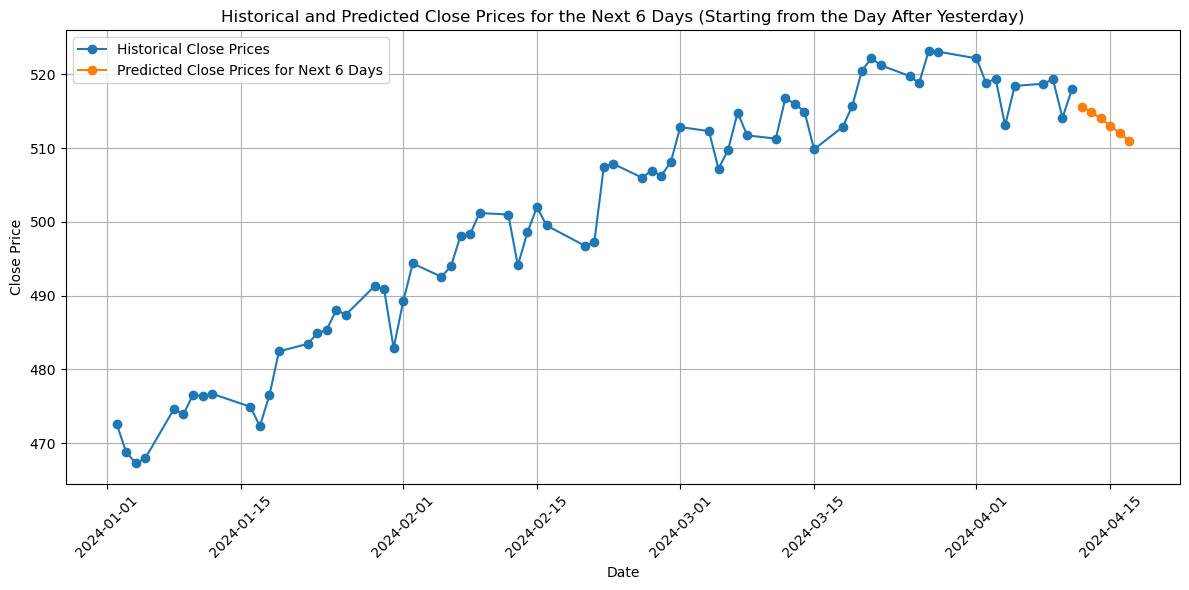

In [24]:
plt.figure(figsize=(12, 6))

# Plotting historical data
plt.plot(data_up_to_yesterday[data_up_to_yesterday['Date'] >= '2024-01-01']['Date'],
         data_up_to_yesterday[data_up_to_yesterday['Date'] >= '2024-01-01']['Close'],
         label='Historical Close Prices',
         marker='o')

# Generating dates for the next 6 days
next_6_days_dates = pd.date_range(start=data_up_to_yesterday['Date'].max() + pd.Timedelta(days=1), periods=6, freq='D')

# Plotting predicted data for the next 6 days
plt.plot(next_6_days_dates,
         predictions_6_days,
         label='Predicted Close Prices for Next 6 Days',
         marker='o')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical and Predicted Close Prices for the Next 6 Days (Starting from the Day After Yesterday)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()